# Markov Decision Process (MDP)

### Ransalu Senanayake

In [ ]:
import copy
import timeit
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets

Create the following grid world.

**States:** A 10x10 grid

**Actions:** Up, Down, Left, Right

**Tranistion probabilities:**
* 0.7 in the direction of action
* 0.1 in the three other directions
* The robot bounces back to the same state near edges

**Rewards:**
* (7,8) has a reward +10
* (2,7) has a reward +3
* (4,3) has a reward -5
* (7,3) has a reward -10
* No reward in other states

This example is based on Decision Making Under Uncertainty by M.J. Kochenderfer.

In [ ]:
#Let's define MDP paras
def createGrid10World():
    def xy2s(y, x):
        x = max(x, 0)
        y = max(y, 0)
        x = min(x, 9)
        y = min(y, 9)
        out = np.ravel_multi_index(np.array([x,y]), (10,10))
        return out

    def s2xy(s):
        x, y = np.unravel_index(s, (10,10))
        return y, x

    def gridPlot(ax, im, title='', cmap='Blues'):
        pl.imshow(im, interpolation='none', cmap=cmap, origin='lower')
        pl.colorbar()
        ax.set_xticks(np.arange(0, 10, 1));
        ax.set_yticks(np.arange(0, 10, 1));
        ax.set_xticklabels(np.arange(0, 10, 1));
        ax.set_yticklabels(np.arange(0, 10, 1));
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True);
        ax.set_yticks(np.arange(-.5, 10, 1), minor=True);
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        pl.title(title);
        return

    A = ['left', 'right', 'up', 'down']
    S = np.arange(100)
    T = np.zeros((len(S), len(A), len(S)))
    R = np.zeros((len(S), len(A)))
    for s in S:
        x, y = s2xy(s)
        if x == 2 and y == 7:
            R[s, :] = 3
        elif x == 7 and y == 8:
            R[s, :] = 10
        else:
            if x == 7 and y == 3:
                R[s, :] = -10
            elif x == 4 and y == 3:
                R[s, :] = -5
            elif x == 0:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 0] = -0.7
            elif x == 9:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 1] = -0.7
            elif y == 0:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 3] = -0.7
            elif y == 9:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 2] = -0.7

            for a in A:
                if a == 'left':
                    T[s, 0, xy2s(x - 1, y)] += 0.7
                    T[s, 0, xy2s(x + 1, y)] += 0.1
                    T[s, 0, xy2s(x, y - 1)] += 0.1
                    T[s, 0, xy2s(x, y + 1)] += 0.1
                elif a == 'right':
                    T[s, 1, xy2s(x + 1, y)] += 0.7
                    T[s, 1, xy2s(x - 1, y)] += 0.1
                    T[s, 1, xy2s(x, y - 1)] += 0.1
                    T[s, 1, xy2s(x, y + 1)] += 0.1
                elif a == 'up':
                    T[s, 2, xy2s(x, y + 1)] += 0.7
                    T[s, 2, xy2s(x, y - 1)] += 0.1
                    T[s, 2, xy2s(x - 1, y)] += 0.1
                    T[s, 2, xy2s(x + 1, y)] += 0.1
                elif a == 'down':
                    T[s, 3, xy2s(x, y - 1)] += 0.7
                    T[s, 3, xy2s(x, y + 1)] += 0.1
                    T[s, 3, xy2s(x - 1, y)] += 0.1
                    T[s, 3, xy2s(x + 1, y)] += 0.1

    for a, c_x, c_y in [(0,0,0), (0,0,9),(1,9,0),(1,9,9),(2,0,9),(2,9,9),(3,0,0),(3,9,0)]:
        R[xy2s(c_x,c_y),a] = -0.8

    discount = 0.9

    nextStates = {}
    for si in range(len(S)):
        for ai in range(len(A)):
            nextStates[(si,ai)] = np.where((T[si, ai, :] != 0) == True)[0]

    return {'S':S, 'A':A, 'T':T, 'R':R, 'discount':discount, 'nextStates':nextStates, 'gridPlot':gridPlot, 'xy2s':xy2s, 's2xy':s2xy}

In [ ]:
class MDP():
    def __init__(self):
        pass

    def inbuilt_init(self, mdp_dict):
        self.S = mdp_dict['S']
        self.A = mdp_dict['A']
        self.T = mdp_dict['T']
        self.R = mdp_dict['R']
        self.discount = mdp_dict['discount']
        self.nextStates = mdp_dict['nextStates']
        self.gridPlot = mdp_dict['gridPlot']
        self.xy2s = mdp_dict['xy2s']
        self.s2xy = mdp_dict['s2xy']

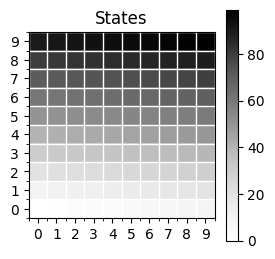

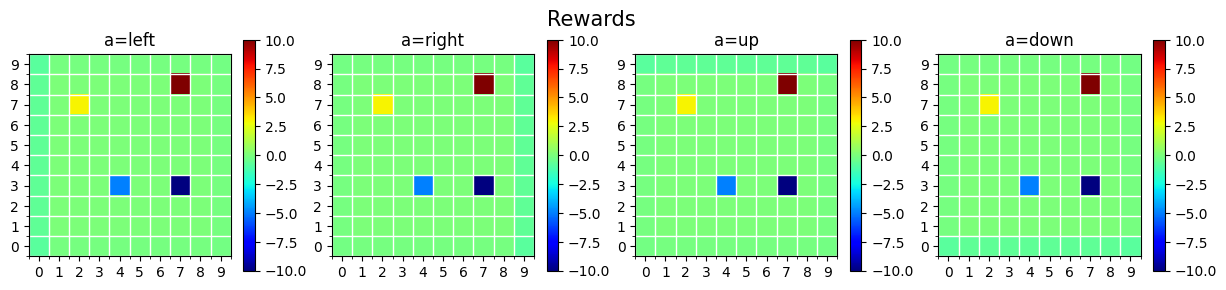

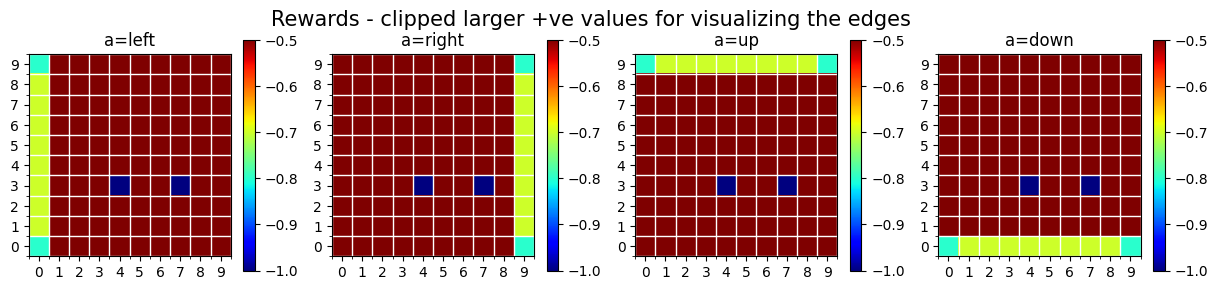

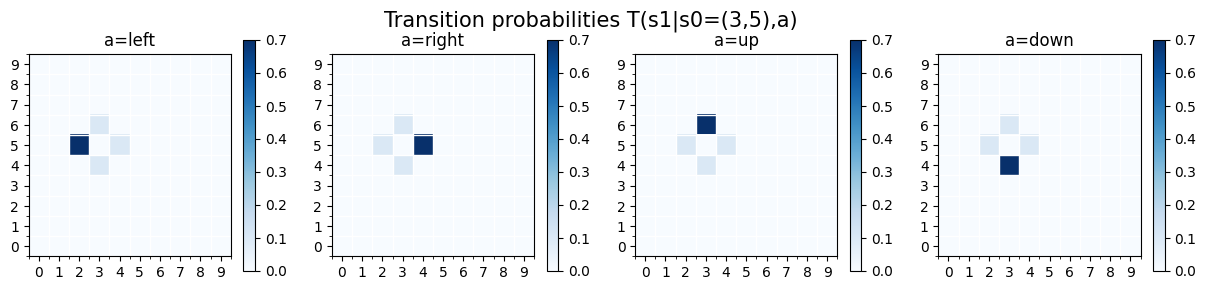

In [ ]:
#Define the MDP
mdp = MDP()
mdp.inbuilt_init(mdp_dict=createGrid10World())

#Plot states
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=mdp.S.reshape((10,10)), title='States', cmap='Greys')

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.R[:,a].reshape((10,10)), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards - clipped larger +ve values for visualizing the edges', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=np.clip(mdp.R[:,a].reshape((10,10)), -1, -0.5), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
s0_x, s0_y = 3, 5
s0 = mdp.xy2s(s0_x, s0_y)
pl.figure(figsize=(15,3))
pl.suptitle('Transition probabilities T(s1|s0=({},{}),a)'.format(s0_x, s0_y), fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title='a='+mdp.A[a], cmap='Blues')
pl.show()

In [ ]:
#An interactive plot of transition probabilities
def f(s0_x, s0_y, action):
    a = mdp.A.index(action)
    s0 = mdp.xy2s(int(s0_x), int(s0_y))
    pl.figure(figsize=(6,6))
    title = 'Transition probabilities T(s1|s0=({},{}),a={})'.format(int(s0_x),int(s0_y),action)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title=title, cmap='Blues')
    pl.show()

interactive_plot = interactive(f, s0_x='4', s0_y='5', action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']))
interactive_plot

interactive(children=(Text(value='4', description='s0_x'), Text(value='5', description='s0_y'), ToggleButtons(…

### 1. Policy evaluation

Computing the utility, U.

$U^\pi_k(s) = R(s, \pi(s)) + \gamma \sum_{s'} T(s' \mid s, \pi(s))U^\pi_{k-1}(s')$

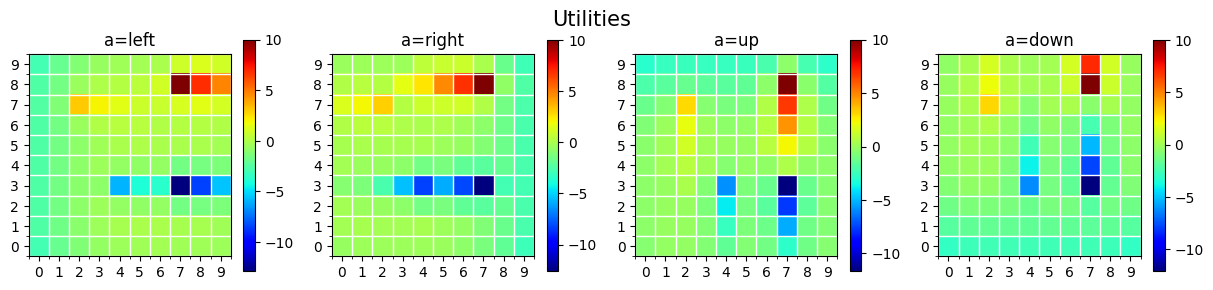

In [ ]:
def iterativePolicyEvaluation(mdp, policy, numIterations=10):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    # Support: policy can be an int (same action for all states) or a vector of per-state actions
    if isinstance(policy, (int, np.integer)):
        pi = np.full(len(mdp.S), int(policy), dtype=int)
    else:
        pi = np.asarray(policy, dtype=int)

    for _ in range(numIterations):
        U_old[:] = U
        # Bellman expectation backup for the fixed policy
        for s in mdp.S:
            a = pi[s]
            U[s] = mdp.R[s, a] + mdp.discount * np.dot(mdp.T[s, a, :], U_old)
    return U

numIterations = 5
pl.figure(figsize=(15,3))
pl.suptitle('Utilities', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    U = iterativePolicyEvaluation(mdp=mdp, policy=a, numIterations=numIterations)
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='a='+mdp.A[a], cmap='jet')
pl.show()
#print(np.round(U.reshape(10,10),3))

In [ ]:
def f(action, numIter=1):
    U = iterativePolicyEvaluation(mdp, policy=mdp.A.index(action), numIterations=numIter)
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    pl.show()

interactive_plot = interactive(f, action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']),
                               numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(ToggleButtons(description='action', options=('left', 'right', 'up', 'down'), value='left…

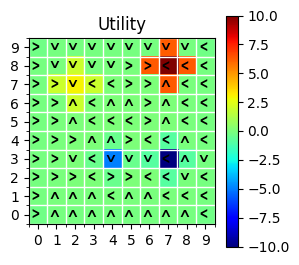

In [ ]:
#Value iteration
def valueIteration(mdp, numIterations=1):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for _ in range(numIterations):
        U_old[:] = U
        for s in mdp.S:
            # Compute Q(s, a) for all actions, then take max_a
            q_sa = np.empty(len(mdp.A))
            for a in range(len(mdp.A)):
                q_sa[a] = mdp.R[s, a] + mdp.discount * np.dot(mdp.T[s, a, :], U_old)
            U[s] = np.max(q_sa)
    return U

def policyExtration(mdp, U):
    policy = np.zeros(len(mdp.S))
    for s in mdp.S:
        q_sa = np.empty(len(mdp.A))
        for a in range(len(mdp.A)):
            q_sa[a] = mdp.R[s, a] + mdp.discount * np.dot(mdp.T[s, a, :], U)
        # Tie-break uniformly among maxima
        max_q = np.max(q_sa)
        best_as = np.flatnonzero(np.isclose(q_sa, max_q))
        policy[s] = np.random.choice(best_as)
    return policy

U = valueIteration(mdp, numIterations=2)
policy = policyExtration(mdp, U=U)
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
for s in range(100):
    x, y = mdp.s2xy(s)
    if policy[s] == 0:
        m='\u02C2'
    elif policy[s] == 1:
        m='\u02C3'
    elif policy[s] == 2:
        m='\u02C4'
    elif policy[s] == 3:
        m='\u02C5'
    pl.text(x-0.5,y-1,m,color='k',size=20)
pl.show()

In [ ]:
def f(numIter=1):
    start_time = timeit.default_timer()
    U = valueIteration(mdp, numIterations=numIter)
    policy = policyExtration(mdp, U=U)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

### 2. Policy iteration

Policy evaluation can be used in policy iteration:
1. Given the current policy, compute U
2. Using U, compute a new policy

In [ ]:
def policyIteration(mdp, numIterations=1):
    U_pi_k = np.zeros(len(mdp.S))                      # Utilities under current policy
    pi_k = np.random.randint(0, 4, size=len(mdp.S))    # Random initial policy
    pi_kp1 = copy.copy(pi_k)

    # You can tune inner evaluation sweeps for stability/speed
    inner_eval_sweeps = 20

    for _ in range(numIterations):
        # Policy evaluation: compute U_pi_k for current policy
        U_pi_k = iterativePolicyEvaluation(mdp, policy=pi_k, numIterations=inner_eval_sweeps)

        # Policy improvement: greedy w.r.t. U_pi_k
        for s in mdp.S:
            q_sa = np.empty(len(mdp.A))
            for a in range(len(mdp.A)):
                q_sa[a] = mdp.R[s, a] + mdp.discount * np.dot(mdp.T[s, a, :], U_pi_k)
            max_q = np.max(q_sa)
            best_as = np.flatnonzero(np.isclose(q_sa, max_q))
            pi_kp1[s] = np.random.choice(best_as)

        # (Optional) Early stop if policy stabilizes
        if np.array_equal(pi_kp1, pi_k):
            break
        pi_k[:] = pi_kp1

    return U_pi_k, pi_kp1

U_pi_k, pi_kp1 = policyIteration(mdp, numIterations=2)

In [ ]:
def f(numIter=1):
    start_time = timeit.default_timer()
    # code you want to evaluate
    value, policy = policyIteration(mdp, numIterations=numIter)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=value.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

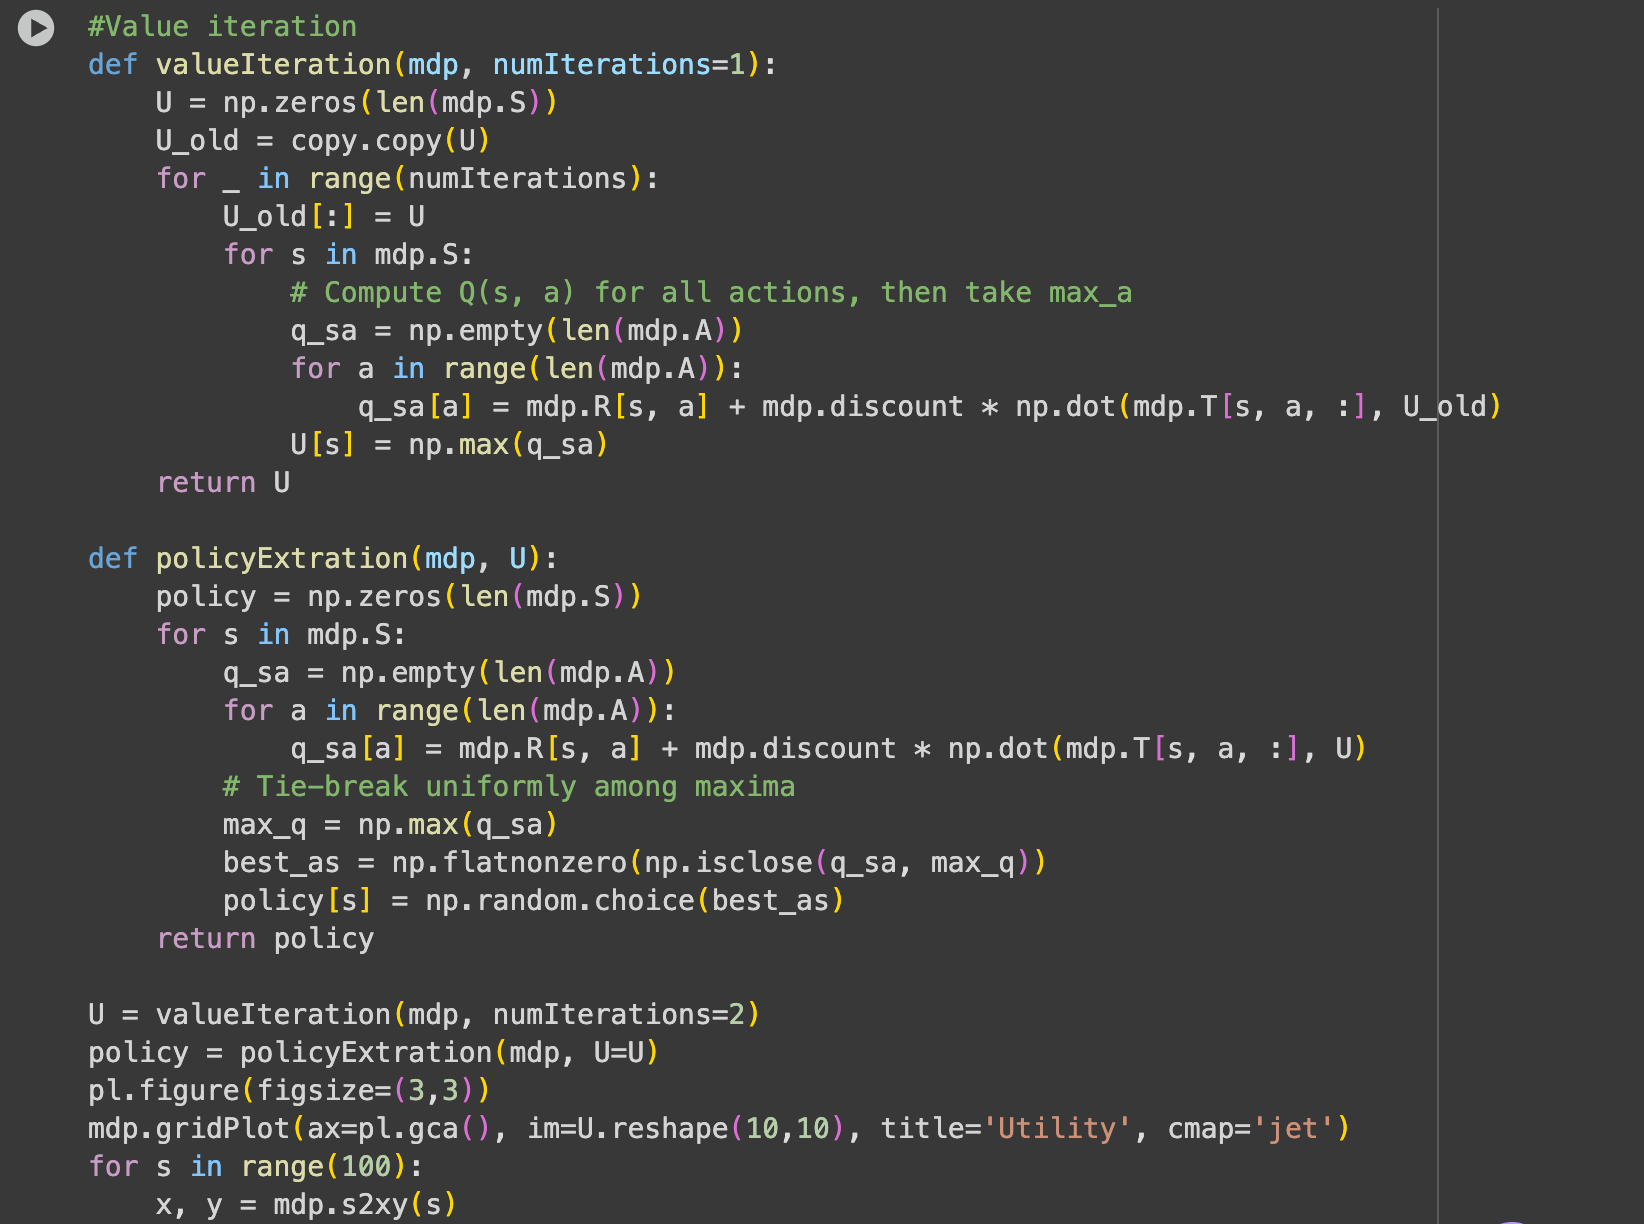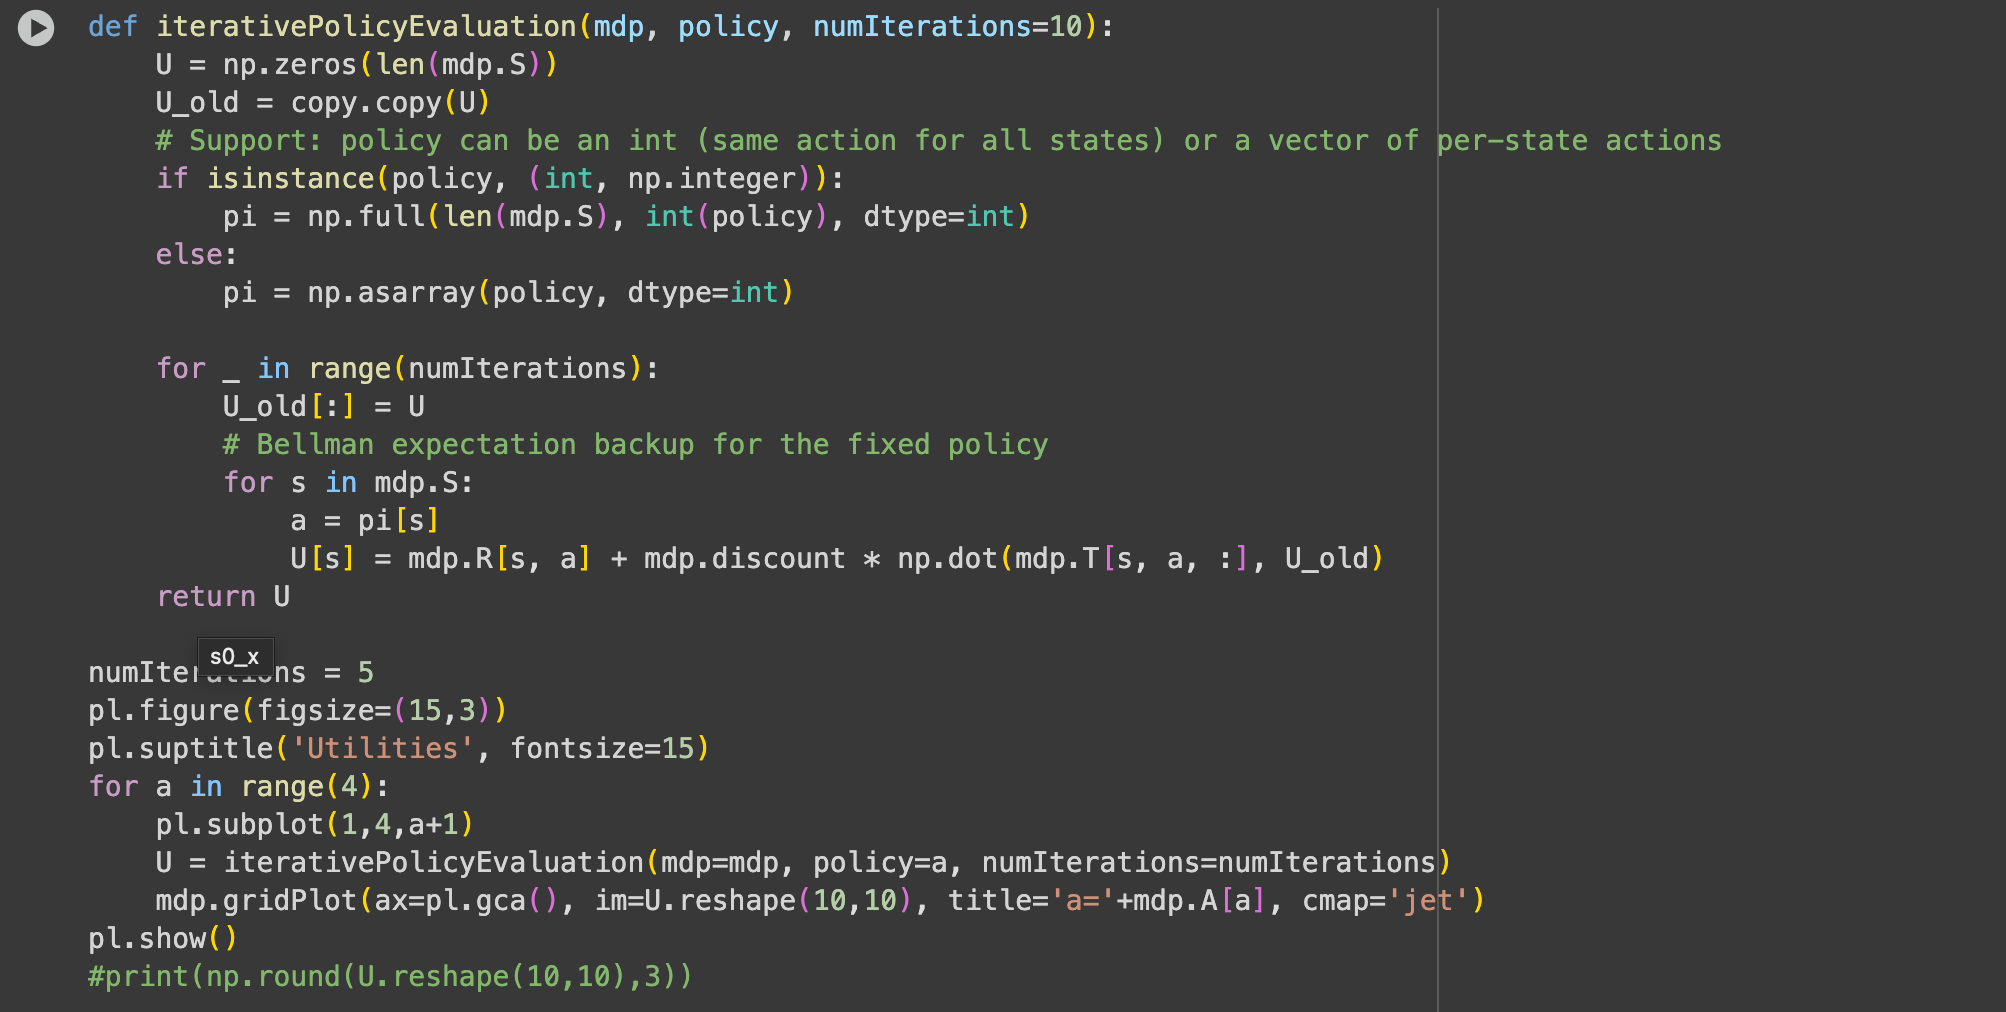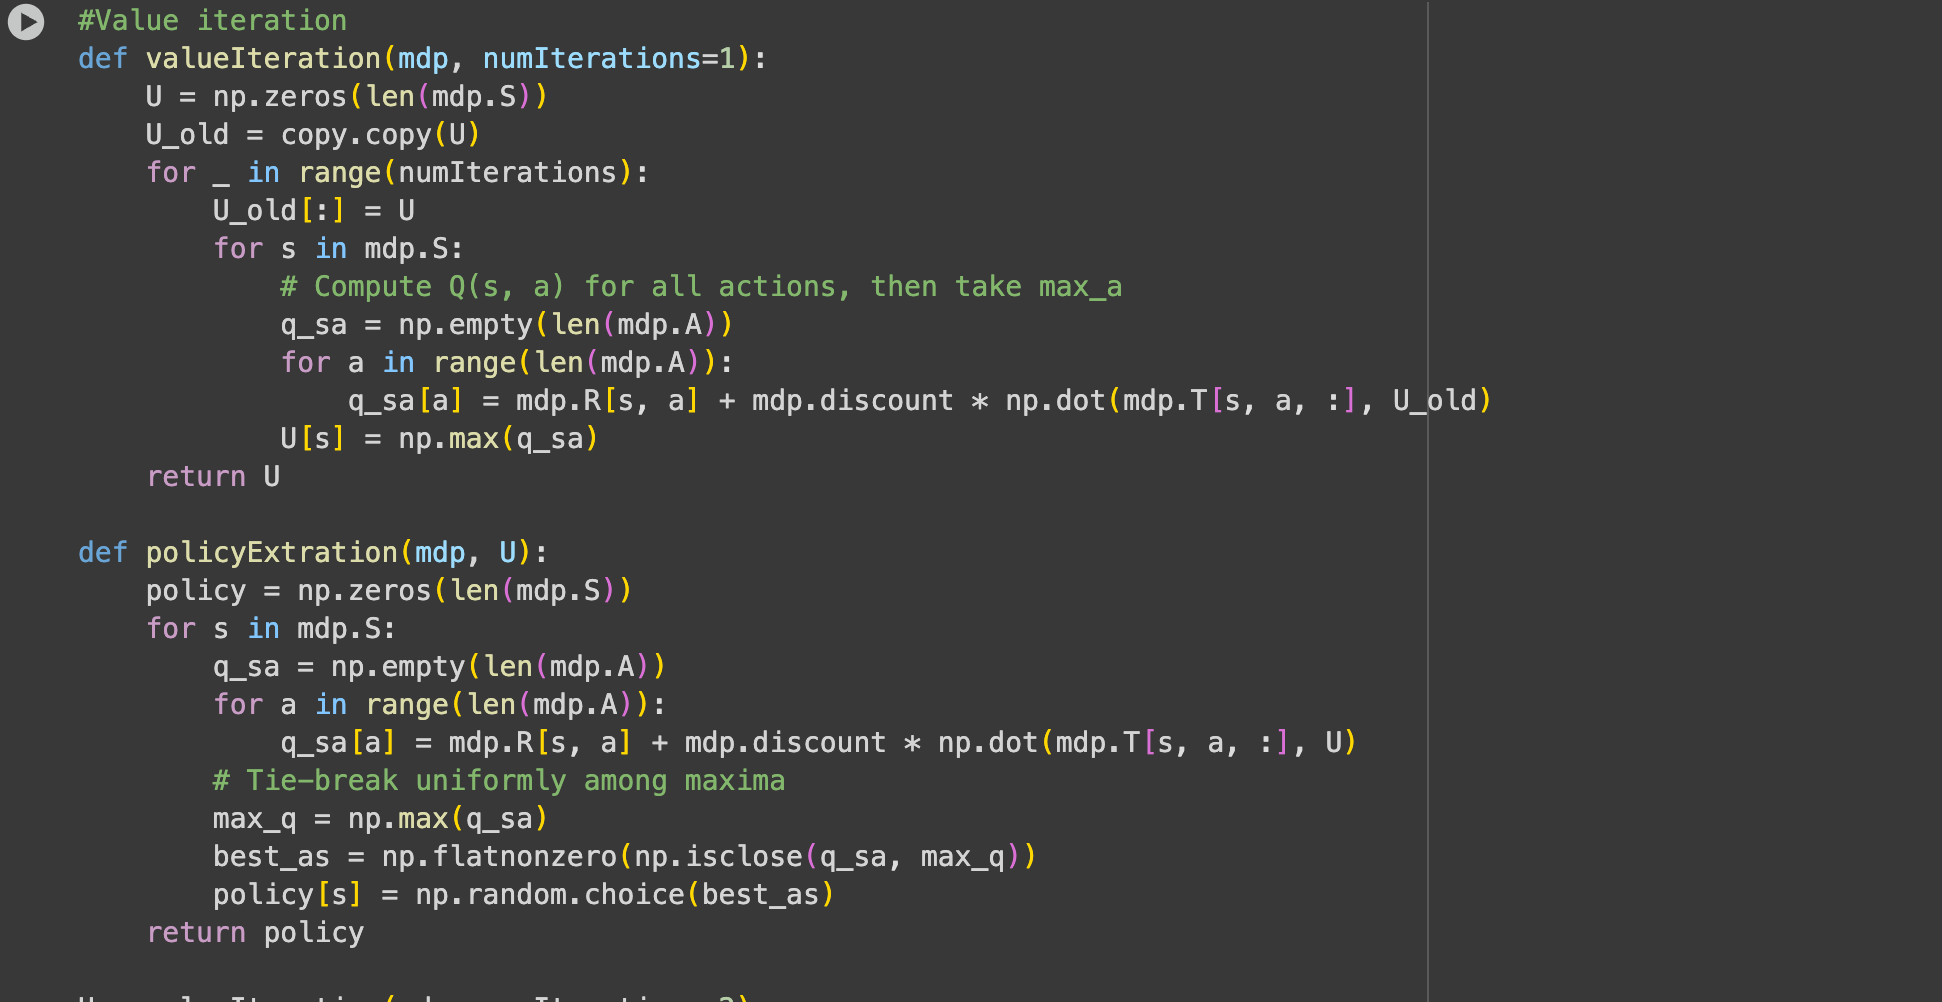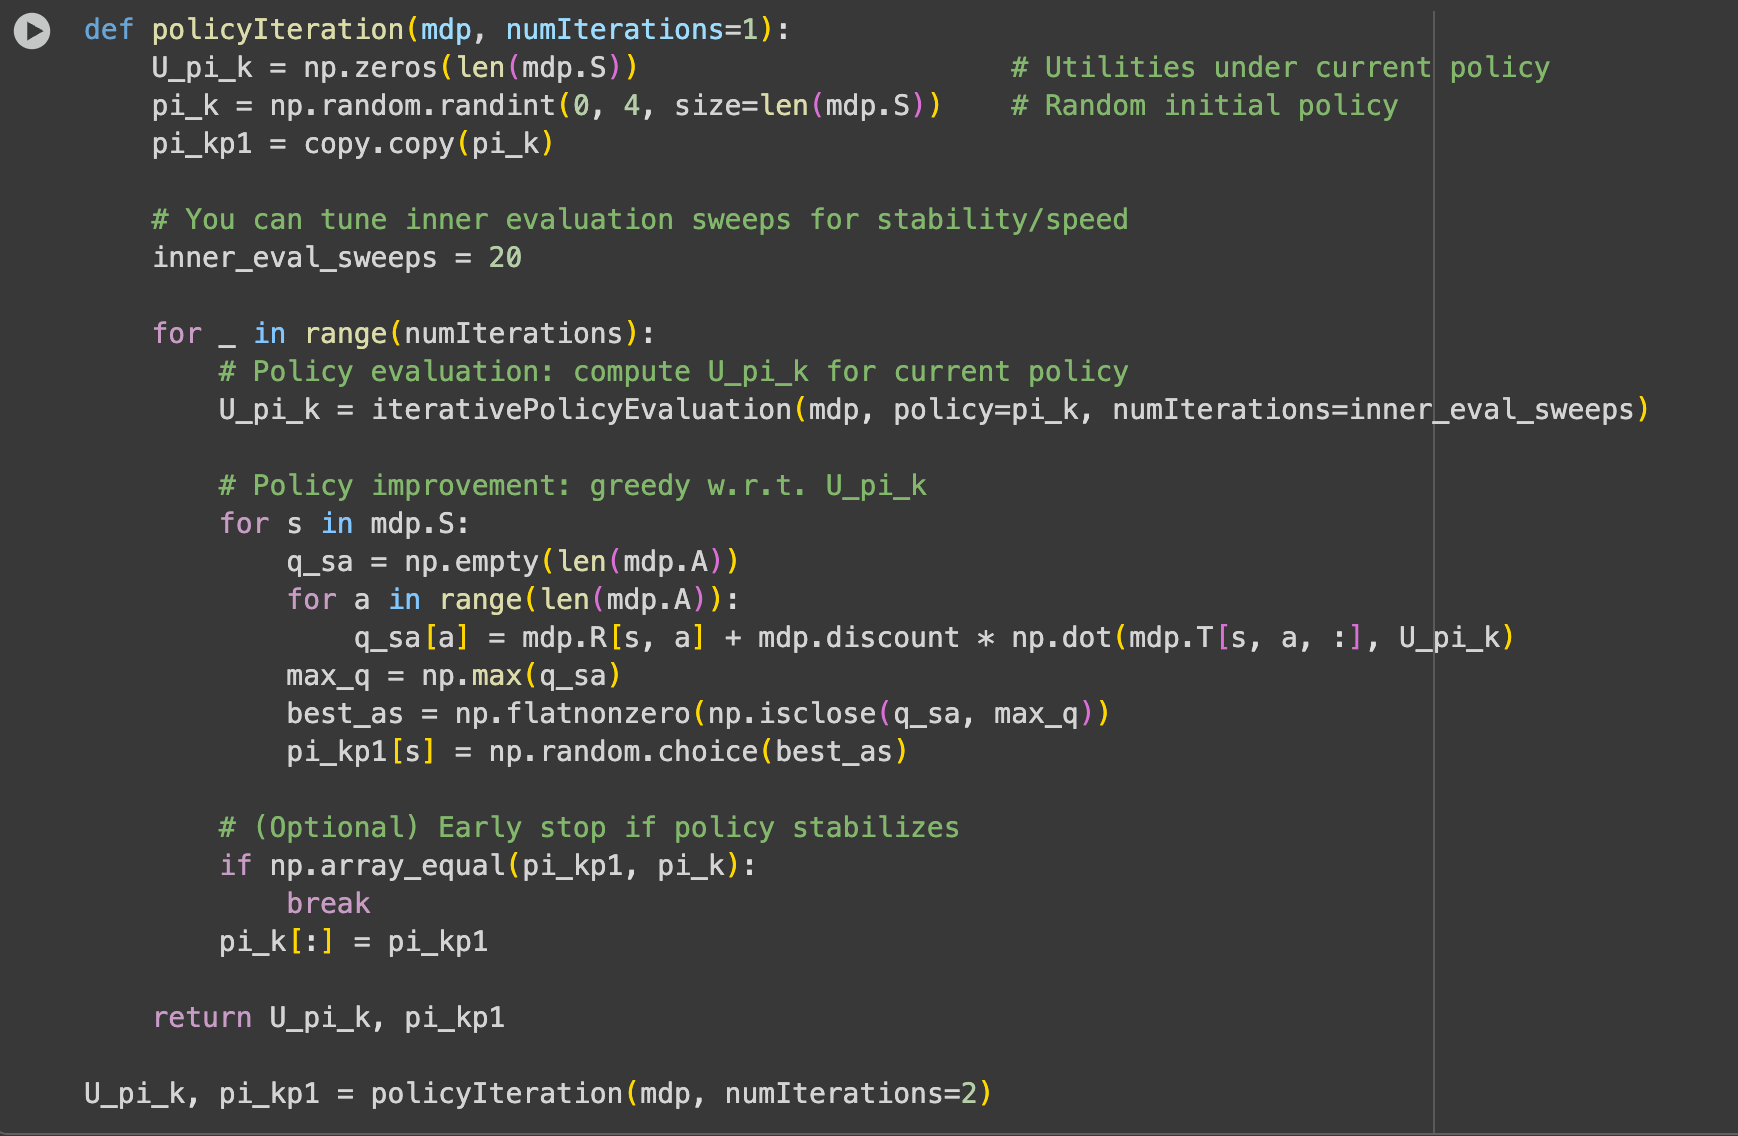

[Value Iteration] iters=61, time=59.7 ms, final max-Bellman-error=6.24e-07


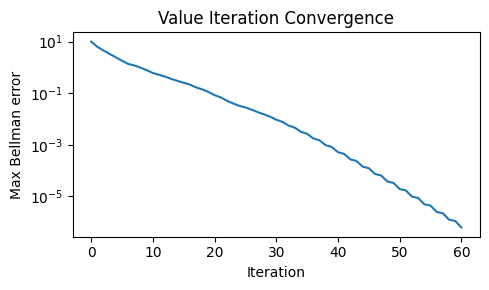

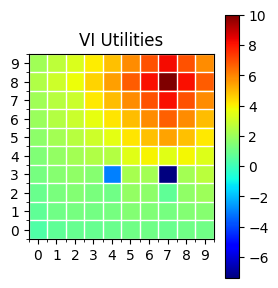

In [ ]:
import timeit
import numpy as np
import matplotlib.pyplot as pl

def value_iteration_timed(mdp, tol=1e-6, max_iter=1000):
    """Returns (U, deltas, wall_time). U is the final utility vector,
       deltas is the per-iteration Bellman error sequence."""
    start = timeit.default_timer()
    U = np.zeros(len(mdp.S))
    deltas = []

    for it in range(max_iter):
        U_old = U.copy()
        # Bellman optimality update
        for s in mdp.S:
            q_sa = mdp.R[s, :] + mdp.discount * (mdp.T[s, :, :] @ U_old)
            U[s] = np.max(q_sa)
        delta = np.max(np.abs(U - U_old))
        deltas.append(delta)
        if delta < tol:
            break

    wall_time = timeit.default_timer() - start
    return U, np.array(deltas), wall_time

U_vi, deltas_vi, t_vi = value_iteration_timed(mdp, tol=1e-6, max_iter=2000)
print(f"[Value Iteration] iters={len(deltas_vi)}, time={t_vi*1000:.1f} ms, final max-Bellman-error={deltas_vi[-1]:.2e}")

# Plot VI convergence curve
pl.figure(figsize=(5,3))
pl.semilogy(deltas_vi)
pl.xlabel("Iteration")
pl.ylabel("Max Bellman error")
pl.title("Value Iteration Convergence")
pl.tight_layout()
pl.savefig("vi_convergence.png", dpi=150)
pl.show()

# Visualize final utilities
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=U_vi.reshape(10,10), title='VI Utilities', cmap='jet')
pl.tight_layout()
pl.savefig("vi_utilities.png", dpi=150)
pl.show()


[Q-Learning] episodes=5000, time=32.74 s, avg return last 100 eps = 744.767


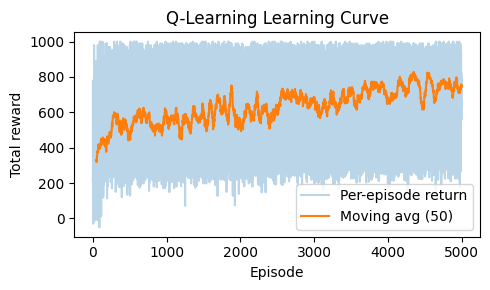

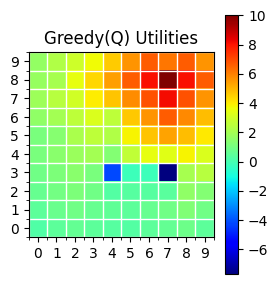

In [ ]:
rng = np.random.default_rng(0)  # reproducibility; change or remove for stochastic runs

def sample_next_state(mdp, s, a, rng):
    # Sample s' ~ T(s,a,·)
    probs = mdp.T[s, a, :]
    # Numerical safety: in case of tiny rounding error, renormalize
    if probs.sum() == 0:
        # Should not happen; fallback to self-loop
        return s
    probs = probs / probs.sum()
    return rng.choice(mdp.S, p=probs)

def q_learning_timed(mdp, episodes=5000, horizon=100, alpha=0.1, epsilon=0.1, gamma=None, seed=0):
    """Returns (Q, returns, wall_time). returns = episodic total rewards."""
    if gamma is None:
        gamma = mdp.discount
    rng = np.random.default_rng(seed)
    Q = np.zeros((len(mdp.S), len(mdp.A)))
    ep_returns = np.zeros(episodes)

    start = timeit.default_timer()
    for ep in range(episodes):
        # Start from a random state (you can change this to a fixed start if you prefer)
        s = int(rng.integers(0, len(mdp.S)))
        G = 0.0

        for t in range(horizon):
            # ε-greedy
            if rng.random() < epsilon:
                a = int(rng.integers(0, len(mdp.A)))
            else:
                # tie-break uniformly among maxima
                max_q = Q[s].max()
                best_as = np.flatnonzero(np.isclose(Q[s], max_q))
                a = int(rng.choice(best_as))

            r = mdp.R[s, a]
            s_next = sample_next_state(mdp, s, a, rng)

            # Q-update
            td_target = r + gamma * Q[s_next].max()
            Q[s, a] += alpha * (td_target - Q[s, a])

            G += r
            s = s_next

        ep_returns[ep] = G

    wall_time = timeit.default_timer() - start
    return Q, ep_returns, wall_time

Q, ep_returns, t_ql = q_learning_timed(
    mdp,
    episodes=5000,   # increase/decrease to see convergence trends
    horizon=100,     # finite-horizon episode
    alpha=0.1,
    epsilon=0.1,
    gamma=mdp.discount,
    seed=0
)

print(f"[Q-Learning] episodes={len(ep_returns)}, time={t_ql:.2f} s, "
      f"avg return last 100 eps = {ep_returns[-100:].mean():.3f}")

# Smooth learning curve for readability
def moving_avg(x, k=50):
    k = max(1, int(k))
    c = np.convolve(x, np.ones(k)/k, mode='valid')
    return c

pl.figure(figsize=(5,3))
pl.plot(ep_returns, alpha=0.3, label="Per-episode return")
pl.plot(np.arange(len(ep_returns)-49)+49, moving_avg(ep_returns, 50), label="Moving avg (50)")
pl.xlabel("Episode")
pl.ylabel("Total reward")
pl.title("Q-Learning Learning Curve")
pl.legend()
pl.tight_layout()
pl.savefig("q_learning_curve.png", dpi=150)
pl.show()

# (Optional) Greedy policy derived from Q and its utility via a single evaluation sweep
greedy_policy = Q.argmax(axis=1)
U_greedy = iterativePolicyEvaluation(mdp, policy=greedy_policy, numIterations=50)

pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=U_greedy.reshape(10,10), title='Greedy(Q) Utilities', cmap='jet')
pl.tight_layout()
pl.savefig("q_greedy_utilities.png", dpi=150)
pl.show()


Model-Based (VI) time:  59.7 ms, iterations: 61
Model-Free (QL) time:   32740.3 ms, episodes: 5000


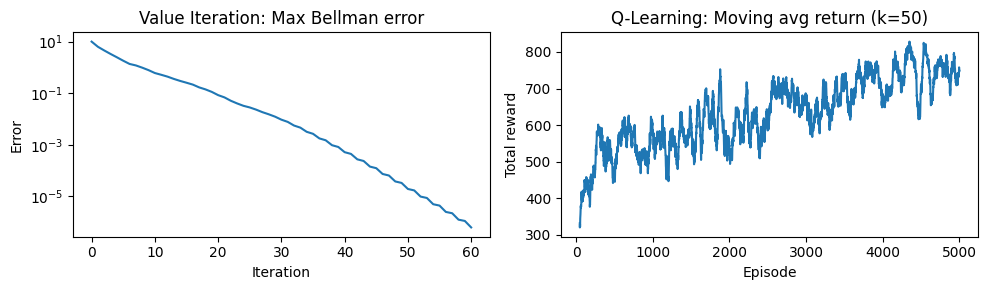

In [ ]:
# Compare wall time
print(f"Model-Based (VI) time:  {t_vi*1000:.1f} ms, iterations: {len(deltas_vi)}")
print(f"Model-Free (QL) time:   {t_ql*1000:.1f} ms, episodes: {len(ep_returns)}")

# Put convergence-ish signals in one figure:
# - VI: Bellman error per iteration (smaller is better)
# - QL: smoothed return per episode (higher is better)
fig, axs = pl.subplots(1, 2, figsize=(10,3))

axs[0].semilogy(deltas_vi)
axs[0].set_title("Value Iteration: Max Bellman error")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Error")

ma = moving_avg(ep_returns, 50)
axs[1].plot(np.arange(len(ep_returns)-49)+49, ma)
axs[1].set_title("Q-Learning: Moving avg return (k=50)")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Total reward")

pl.tight_layout()
pl.savefig("mb_vs_mf_comparison.png", dpi=150)
pl.show()


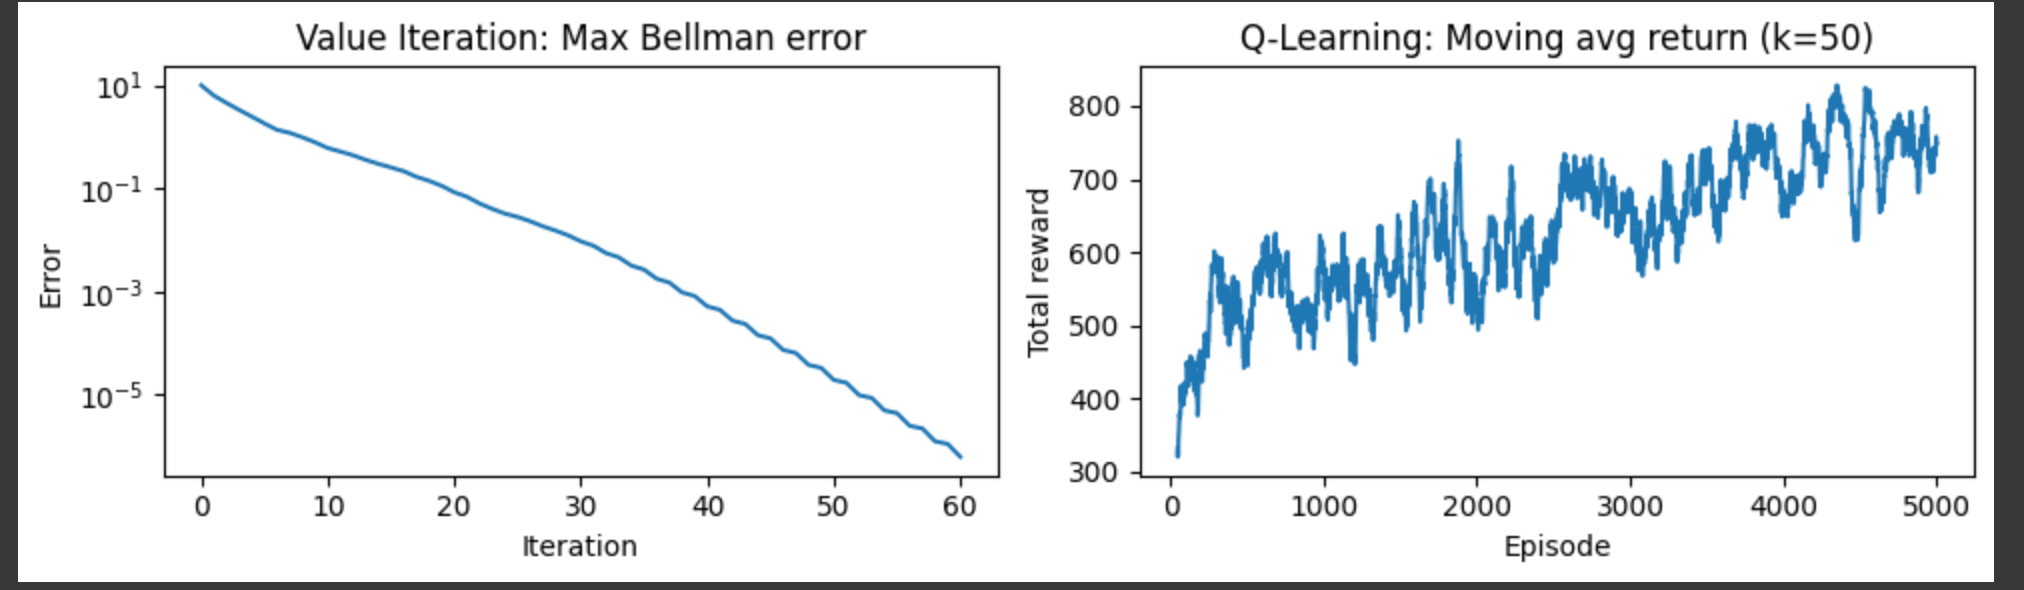Model-Based vs Model-Free RL (short note)
Model-Based algorithms assume (or learn) a model of the environment’s dynamics
T
(
s
′
∣
s
,
a
)
T(s
′
 ∣s,a) and rewards
R
(
s
,
a
)
R(s,a). They plan using that model.
• Examples here: Value Iteration and Policy Iteration, which update a value function with expected next-state utilities under the known
T
T.
• They typically converge in fewer iterations and provide guarantees when the model is accurate, but require the model (and computing full expectations across all next states).
Model-Free algorithms learn to act without an explicit dynamics model, relying on trial-and-error experience.
• Example here: Q-Learning, which updates
Q
(
s
,
a
)
Q(s,a) using sampled transitions
(
s
,
a
,
r
,
s
′
)
(s,a,r,s
′
 ).
• They can be used when
T
T is unknown or hard to model, but usually need many more samples (episodes) to converge and their performance depends on exploration, learning rate schedules, and stochasticity.
In this notebook: Value Iteration reaches a fixed point (small Bellman error) quickly, while Q-Learning’s return improves gradually over many episodes. Wall-time differs depending on problem size: VI does heavier computation per iteration; Q-Learning spreads computation over many sampled episodes.